In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

from tokenizer import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.nn import functional as F
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [40]:
df_train = pd.read_parquet('hackathon_types/hackaton_train_types_recom.parquet', engine='fastparquet')
df_train.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0


In [41]:
df_test = pd.read_parquet('hackathon_types/hackaton_test_types_recom.parquet', engine='fastparquet')
df_test.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
97704,https://cdn1.ozone.ru/s3/multimedia-1-h/714445...,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1
446046,https://cdn1.ozone.ru/s3/multimedia-1-q/719594...,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1
511281,https://cdn1.ozone.ru/s3/multimedia-1-w/722827...,"Интерьерная картина ""Кирпичи в руинах древней ...",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/696992...,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет ч...",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0


In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763013 entries, 6762112 to 724995
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       763013 non-null  object
 1   name             763013 non-null  object
 2   type             763013 non-null  object
 3   category_l2      442407 non-null  object
 4   category_l4      442407 non-null  object
 5   is_markup        763013 non-null  bool  
 6   target           763013 non-null  int64 
 7   stratify_column  763013 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 47.3+ MB


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190754 entries, 7809846 to 6192728
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       190754 non-null  object
 1   name             190754 non-null  object
 2   type             190754 non-null  object
 3   category_l2      110603 non-null  object
 4   category_l4      110603 non-null  object
 5   is_markup        190754 non-null  bool  
 6   target           190754 non-null  int64 
 7   stratify_column  190754 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 11.8+ MB


In [44]:
df_train['category_l2'].value_counts()

category_l2
Дом и сад                           85209
Строительство и ремонт              56802
Автотовары                          55200
Одежда                              38964
Электроника                         35556
Галантерея и аксессуары             18544
Мебель                              17938
Обувь                               17756
Детские товары                      17320
Красота и гигиена                   15948
Спорт и отдых                       15346
Хобби и творчество                  15097
Товары для животных                  8932
Бытовая техника                      8479
Канцелярские товары                  8060
Аптека                               6499
Книги                                5286
Товары для взрослых                  4737
Продукты питания                     2790
Продукты питания Ozon Fresh          1529
Антиквариат и коллекционирование     1467
Бытовая химия                        1199
Музыкальные инструменты              1088
Ювелирные изделия     

In [45]:
df_train['category_l4'].value_counts()

category_l4
Картина                             24323
Фотообои                            17592
Матрас                              11930
Светильник для дома                 11264
Автофильтры                         10888
                                    ...  
Детский набор для ухода                 1
Инструмент для зубных протезов          1
Керамогранит                            1
Печатное издание: Блокнот с ISBN        1
Теннисный стол                          1
Name: count, Length: 3381, dtype: int64

In [46]:
df_train['type'].value_counts()

type
Картина                                        24143
Фотообои                                       15650
Матрас                                         11952
Постер                                          9229
Проживание в пансионате                         5304
                                               ...  
Термометр для сельскохозяйственных животных        1
Масло овсяное                                      1
Оселок                                             1
Табло для бильярда                                 1
Инвертор подсветки для авто                        1
Name: count, Length: 19981, dtype: int64

In [47]:
df_tmp = df_train.copy()

# одновременно пусты?
# есть пересечения
print(df_tmp['category_l2'].isin(df_tmp['category_l4']).any())
df_tmp_emp = df_tmp[df_tmp['category_l2'].isin(df_tmp['category_l4'])]
df_tmp_emp

True


,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0
...,...,...,...,...,...,...,...,...
1840277,https://cdn1.ozone.ru/multimedia/1025361785.JPG,"Brabantia Мусорный бак Bo Touch Bin, 36 л",Ящик для игрушек,None,None,False,0,nan_False_0
5068565,https://cdn1.ozone.ru/s3/multimedia-e/66774349...,Портативный ДВД плеер с цифровым телевизором D...,Электрический кусторез,None,None,False,0,nan_False_0
4782795,https://cdn1.ozone.ru/s3/multimedia-1-u/723227...,"Зеркало ректальное аноскоп, с косым срезом, од...",Зеркало гинекологическое,None,None,False,1,nan_False_1
5361388,https://cdn1.ozone.ru/s3/multimedia-1-p/703632...,Стеллаж металлический комплект 6 кронштейн 2 ш...,Стеллаж настенный,None,None,False,1,nan_False_1


In [48]:
print(df_tmp_emp.shape)
print(df_tmp_emp[~df_tmp_emp['category_l2'].isnull()].shape)
print(df_tmp_emp[~df_tmp_emp['category_l4'].isnull()].shape)
print(df_train[df_train['category_l2'].isnull()].shape)
# одновременно пусты

(320606, 8)
(0, 8)
(0, 8)
(320606, 8)


In [49]:
df_tmp_cl = df_tmp[~df_tmp['category_l2'].isnull()]
df_tmp_cl

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
230835,https://cdn1.ozone.ru/s3/multimedia-1-d/719643...,Кроссовки Air Jordan JT 2 Баскетбольная обувь ...,Моноласта,Обувь,Кроссовки,True,0,Обувь_True_0
150710,https://cdn1.ozone.ru/s3/multimedia-1-r/711064...,Подвесной держатель для медалей,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,True,0,Дом и сад_True_0
755744,https://cdn1.ozone.ru/s3/multimedia-8/66493270...,Кроссовки adidas,Кроссовки,Обувь,Кроссовки,False,1,Обувь_False_1
419457,https://cdn1.ozone.ru/s3/multimedia-w/64482028...,"Набор для глинтвейна, смесь для глинтвейна, гл...",Набор для приготовления настойки,Продукты питания,"Смесь приправ, специй и трав",True,1,Продукты питания_True_1
806916,https://cdn1.ozone.ru/s3/multimedia-4/64547959...,Багажник Атлант для Ford Connect / Форд Коннек...,Багажный бокс (автобокс),Автотовары,Багажный бокс (автобокс),True,1,Автотовары_True_1
...,...,...,...,...,...,...,...,...
175977,https://cdn1.ozone.ru/s3/multimedia-1-z/719771...,Планограмма для кофемашин Bluetec G23,Проживание в пансионате,Бытовая техника,Запчасти к технике для кухни,True,0,Бытовая техника_True_0
800232,https://cdn1.ozone.ru/s3/multimedia-1-u/718199...,Щетка для ванны с мягкой щетиной и задней щетк...,Мочалка,Красота и гигиена,Мочалка,True,1,Красота и гигиена_True_1
50897,https://cdn1.ozone.ru/s3/multimedia-i/63954101...,Матрас Lonax Latex Medium S1000 5 Zone 130х195...,Матрас,Мебель,Матрас,False,1,Мебель_False_1
156898,https://cdn1.ozone.ru/s3/multimedia-1-u/720158...,Перкуссия,Барабаны для ударной установки,Музыкальные инструменты,Ударные инструменты,True,1,Музыкальные инструменты_True_1


In [50]:
df_tmp_cl['category_l2'].isin(df_tmp_cl['category_l4']).value_counts()

category_l2
False    442407
Name: count, dtype: int64

In [51]:
df_tmp_cl['category_l4'].isin(df_tmp_cl['category_l2']).value_counts()
# значения не пересекаются

category_l4
False    442407
Name: count, dtype: int64

In [52]:
cat_dicts = [(idx, df_train[df_train['category_l2'] == idx]['category_l4'].value_counts().index) for idx in df_train['category_l2'].value_counts().index]
cat_dicts

[('Дом и сад',
  Index(['Картина', 'Постер', 'Саженец, рассада', 'Кружка', 'Картина модульная',
         'Семена', 'Комплект постельного белья', 'Ширма',
         'Медаль, ленты, кубки сувенирные', 'Клубни, корни, луковицы',
         ...
         'Бар декоративный', 'Аксессуары и комплектующие для термосов',
         'Дуршлаг', 'Мортира пиротехническая',
         'Садовая химия - пестицид, агрохимикат', 'Коврик для бани',
         'Адаптер для индукционной плиты ', 'Дровокол ручной', 'Урна для праха',
         'Тестер воды'],
        dtype='object', name='category_l4', length=492)),
 ('Строительство и ремонт',
  Index(['Фотообои', 'Светильник для дома', 'Прочая оснастка',
         'Настенный светильник', 'Ключ', 'Набор инструментов',
         'Фитинг сантехнический', 'Распределительный бокс', 'Выключатель',
         'Кронштейны, держатели, шланги, штанги',
         ...
         'Газорегуляторная аппаратура',
         'Клеевой пистолет строительный/ремонтный', 'Армирующая лента',
      

Скорее всего category_l4 это подкатегории category_l2 и от выбора category_l2 зависит какие категории category_l4 будут доступны к выбору

Дальше рассматриваем только category_l2

In [53]:
df_train['category_l2'].value_counts().shape

(28,)

In [54]:
df_test['category_l2'].value_counts().shape

(28,)

In [55]:
df_cl = df_train[~df_train['category_l2'].isnull()]
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442407 entries, 230835 to 14010
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       442407 non-null  object
 1   name             442407 non-null  object
 2   type             442407 non-null  object
 3   category_l2      442407 non-null  object
 4   category_l4      442407 non-null  object
 5   is_markup        442407 non-null  bool  
 6   target           442407 non-null  int64 
 7   stratify_column  442407 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 27.4+ MB


In [56]:
df_test_cl = df_test[~df_test['category_l2'].isnull()]
df_test_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110603 entries, 97704 to 837579
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       110603 non-null  object
 1   name             110603 non-null  object
 2   type             110603 non-null  object
 3   category_l2      110603 non-null  object
 4   category_l4      110603 non-null  object
 5   is_markup        110603 non-null  bool  
 6   target           110603 non-null  int64 
 7   stratify_column  110603 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 6.9+ MB


In [57]:
df_test_cl = df_test_cl[df_test_cl['target'] == 1]
df_cl = df_cl[df_cl['target'] == 1]

In [58]:
LE = LabelEncoder()
df_cl['cat'] = LE.fit_transform(df_cl['category_l2'])
df_cl['cat'].head()

755744    15
419457    17
806916     1
504507     8
908607    20
Name: cat, dtype: int64

In [59]:
df_test_cl['cat'] = LE.transform(df_test_cl['category_l2'])
df_test_cl['cat'].head()

97704      8
446046    20
511281     8
52215     20
285585     8
Name: cat, dtype: int64

In [60]:
df_cl['cat'].value_counts()

cat
8     67587
20    39285
1     36002
16    27519
26    18603
6     15828
13    15754
15    12931
7      7596
19     7068
25     6485
12     5970
11     5243
22     4059
4      3839
9      3664
21     2829
3      2219
17     1043
18     1035
27      997
10      581
2       486
14      370
5       370
24      293
0        96
23       64
Name: count, dtype: int64

In [61]:
df_cl['cat'].value_counts().shape

(28,)

In [62]:
train_X_name= df_cl['name']
train_y_name = df_cl['cat']
train_X_name.head()

755744                                     Кроссовки adidas
419457    Набор для глинтвейна, смесь для глинтвейна, гл...
806916    Багажник Атлант для Ford Connect / Форд Коннек...
504507    Кружка латте керамическая большая для чая и ко...
908607    Фотообои моющиеся ударопрочные "Космос в стиле...
Name: name, dtype: object

In [63]:
test_X_name= df_test_cl['name']
test_y_name = df_test_cl['cat']
test_X_name.head()

97704     Кружка латте керамическая большая для чая и ко...
446046    Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...
511281    Интерьерная картина "Кирпичи в руинах древней ...
52215                                               Бра LED
285585    Большой постер "Цветы в стиле густав климт, ор...
Name: name, dtype: object

In [64]:
train_y_name.head()

755744    15
419457    17
806916     1
504507     8
908607    20
Name: cat, dtype: int64

In [65]:
train_y_name.shape

(287816,)

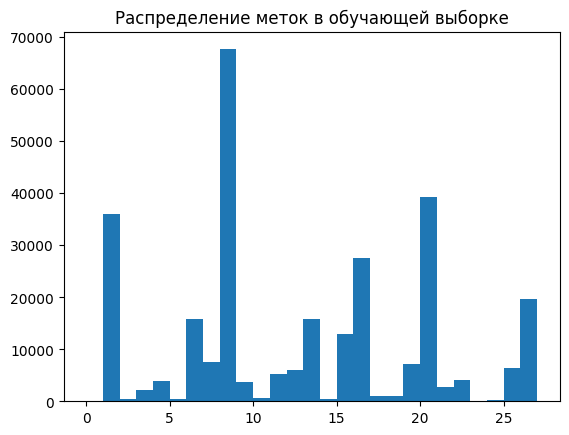

In [66]:
plt.hist(train_y_name, bins=np.arange(0, 28))
plt.title('Распределение меток в обучающей выборке');

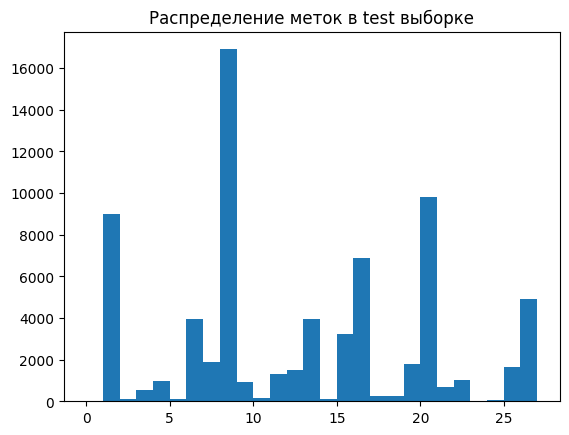

In [67]:
plt.hist(test_y_name, bins=np.arange(0, 28))
plt.title('Распределение меток в test выборке');

In [68]:
train_X_name.head()

755744                                     Кроссовки adidas
419457    Набор для глинтвейна, смесь для глинтвейна, гл...
806916    Багажник Атлант для Ford Connect / Форд Коннек...
504507    Кружка латте керамическая большая для чая и ко...
908607    Фотообои моющиеся ударопрочные "Космос в стиле...
Name: name, dtype: object

In [69]:
tt = tokenize(train_X_name.iloc[0])
tt

['кроссовки', 'adidas']

In [70]:
v = TfidfVectorizer(tokenizer=tokenize)

v_tr_X = v.fit_transform(train_X_name)

v_tr_X.shape

/Users/elenko/Documents/магистратура/vkr/projects/venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(287816, 168172)

In [71]:
v_tr_X[0].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [72]:
MAX_DF = 0.9
MIN_COUNT = 1

name_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
name_pipeline.fit(train_X_name, train_y_name)

/Users/elenko/Documents/магистратура/vkr/projects/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.9,
                                 tokenizer=<function tokenize at 0x13fe97f70>)),
                ('cls', LogisticRegression())])

In [73]:
name_train_pred = name_pipeline.predict_proba(train_X_name)
name_test_pred = name_pipeline.predict_proba(test_X_name)

name_train_loss = F.cross_entropy(torch.from_numpy(name_train_pred), torch.tensor(train_y_name.values))
print('Среднее значение функции потерь на обучении', float(name_train_loss))

name_test_loss = F.cross_entropy(torch.from_numpy(name_test_pred), torch.tensor(test_y_name.values))
print('Среднее значение функции потерь на валидации', float(name_test_loss))

Среднее значение функции потерь на обучении 2.5332061520721627
Среднее значение функции потерь на валидации 2.5393083262407807


In [74]:
print('Доля верных ответов', accuracy_score(train_y_name, name_train_pred.argmax(-1)))
print()

print('Доля верных ответов', accuracy_score(test_y_name, name_test_pred.argmax(-1)))

Доля верных ответов 0.9503259026600328

Доля верных ответов 0.9330970745604892


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

average{‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’
This parameter is required for multiclass/multilabel targets. If None, the metrics for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'binary'
:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

'micro'
:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro'
:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted'
:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

'samples'
:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

In [75]:
print('f1_score', f1_score(train_y_name, name_train_pred.argmax(-1), average='micro'))
print()

print('f1_score', f1_score(test_y_name, name_test_pred.argmax(-1), average='micro'))

f1_score 0.9503259026600328

f1_score 0.9330970745604892


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

average{‘micro’, ‘macro’, ‘samples’, ‘weighted’} or None, default=’macro’
If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Note: multiclass ROC AUC currently only handles the ‘macro’ and ‘weighted’ averages. For multiclass targets, average=None is only implemented for multi_class='ovr' and average='micro' is only implemented for multi_class='ovr'.

'micro'
:
Calculate metrics globally by considering each element of the label indicator matrix as a label.

'macro'
:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted'
:
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

'samples'
:
Calculate metrics for each instance, and find their average.

Will be ignored when y_true is binary.


multi_class{‘raise’, ‘ovr’, ‘ovo’}, default=’raise’
Only used for multiclass targets. Determines the type of configuration to use. The default value raises an error, so either 'ovr' or 'ovo' must be passed explicitly.

'ovr'
:
Stands for One-vs-rest. Computes the AUC of each class against the rest [3] [4]. This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.

'ovo'
:
Stands for One-vs-one. Computes the average AUC of all possible pairwise combinations of classes [5]. Insensitive to class imbalance when average == 'macro'.

In [76]:
print('roc_auc_score', roc_auc_score(train_y_name, name_train_pred, multi_class='ovr'))
print()

print('roc_auc_score', roc_auc_score(test_y_name, name_test_pred, multi_class='ovr'))

roc_auc_score 0.9971680859138986

roc_auc_score 0.9942848973958022


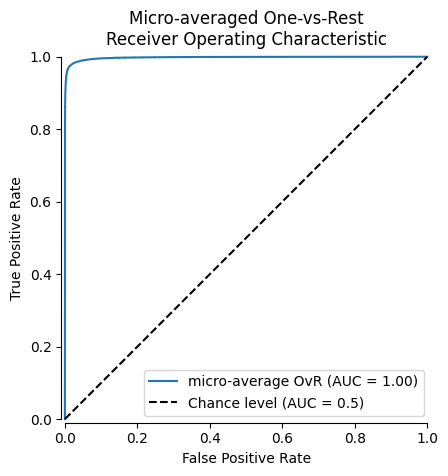

In [77]:
label_binarizer = LabelBinarizer().fit(train_y_name)
y_onehot_test = label_binarizer.transform(test_y_name)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    name_test_pred.ravel(),
    name="micro-average OvR",
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

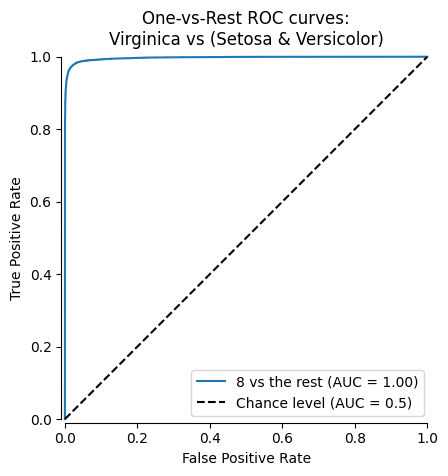

In [78]:
class_id = 8

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    name_test_pred[:, class_id],
    name=f"8 vs the rest",
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)

# Name + type

In [79]:
df_cl['data'] = df_cl['name'] + ' ' + df_cl['type']

train_X_name_type= df_cl['data']
train_y_name_type = df_cl['cat']
train_X_name_type.head()

755744                           Кроссовки adidas Кроссовки
419457    Набор для глинтвейна, смесь для глинтвейна, гл...
806916    Багажник Атлант для Ford Connect / Форд Коннек...
504507    Кружка латте керамическая большая для чая и ко...
908607    Фотообои моющиеся ударопрочные "Космос в стиле...
Name: data, dtype: object

In [80]:
df_test_cl['data'] = df_test_cl['name'] + ' ' + df_test_cl['type']

test_X_name_type= df_test_cl['data']
test_y_name_type = df_test_cl['cat']
test_X_name_type.head()

97704     Кружка латте керамическая большая для чая и ко...
446046    Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...
511281    Интерьерная картина "Кирпичи в руинах древней ...
52215                          Бра LED Подсветка для картин
285585    Большой постер "Цветы в стиле густав климт, ор...
Name: data, dtype: object

In [81]:
MAX_DF = 0.9
MIN_COUNT = 1

name_type_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
name_type_pipeline.fit(train_X_name_type, train_y_name_type)

/Users/elenko/Documents/магистратура/vkr/projects/venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/elenko/Documents/магистратура/vkr/projects/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.9,
                                 tokenizer=<function tokenize at 0x13fe97f70>)),
                ('cls', LogisticRegression())])

In [82]:
name_type_train_pred = name_type_pipeline.predict_proba(train_X_name_type)
name_type_test_pred = name_type_pipeline.predict_proba(test_X_name_type)

sklearn_train_loss = F.cross_entropy(torch.from_numpy(name_type_train_pred), torch.tensor(train_y_name_type.values))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))

sklearn_test_loss = F.cross_entropy(torch.from_numpy(name_type_test_pred), torch.tensor(test_y_name_type.values))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))

Среднее значение функции потерь на обучении 2.478056251365687
Среднее значение функции потерь на валидации 2.480914457141755


In [83]:
print('roc_auc_score train', roc_auc_score(train_y_name_type, name_type_train_pred, multi_class='ovr'))
print()

print('roc_auc_score test', roc_auc_score(test_y_name_type, name_type_test_pred, multi_class='ovr'))

roc_auc_score train 0.999721877940513

roc_auc_score test 0.9991062790200761


In [84]:
print('f1_score train', f1_score(train_y_name_type, name_type_train_pred.argmax(-1), average='micro'))
print()

print('f1_score test', f1_score(test_y_name_type, name_type_test_pred.argmax(-1), average='micro'))

f1_score train 0.9816549462156378

f1_score test 0.9742199986102426


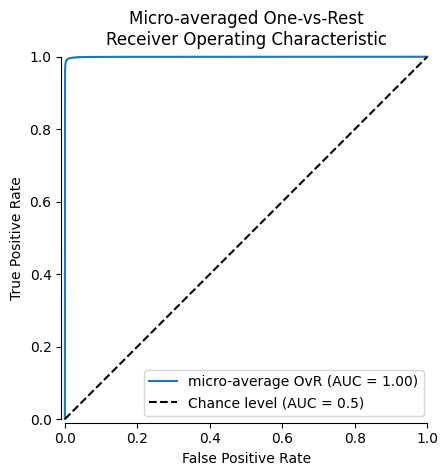

In [85]:
label_binarizer_type = LabelBinarizer().fit(train_y_name_type)
y_onehot_test_type = label_binarizer_type.transform(test_y_name_type)

display = RocCurveDisplay.from_predictions(
    y_onehot_test_type.ravel(),
    name_type_test_pred.ravel(),
    name="micro-average OvR",
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

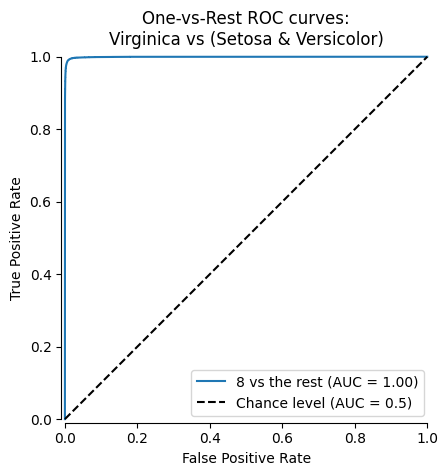

In [86]:
# 8 - Дом и сад
class_id = 8

display = RocCurveDisplay.from_predictions(
    y_onehot_test_type[:, class_id],
    name_type_test_pred[:, class_id],
    name=f"8 vs the rest",
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)

In [87]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test_type.ravel(), name_type_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9997


In [88]:
n_classes = 28

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test_type[:, i], name_type_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.9990


In [89]:
macro_roc_auc_ovr = roc_auc_score(
    test_y_name_type,
    name_type_test_pred,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.4f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.9991


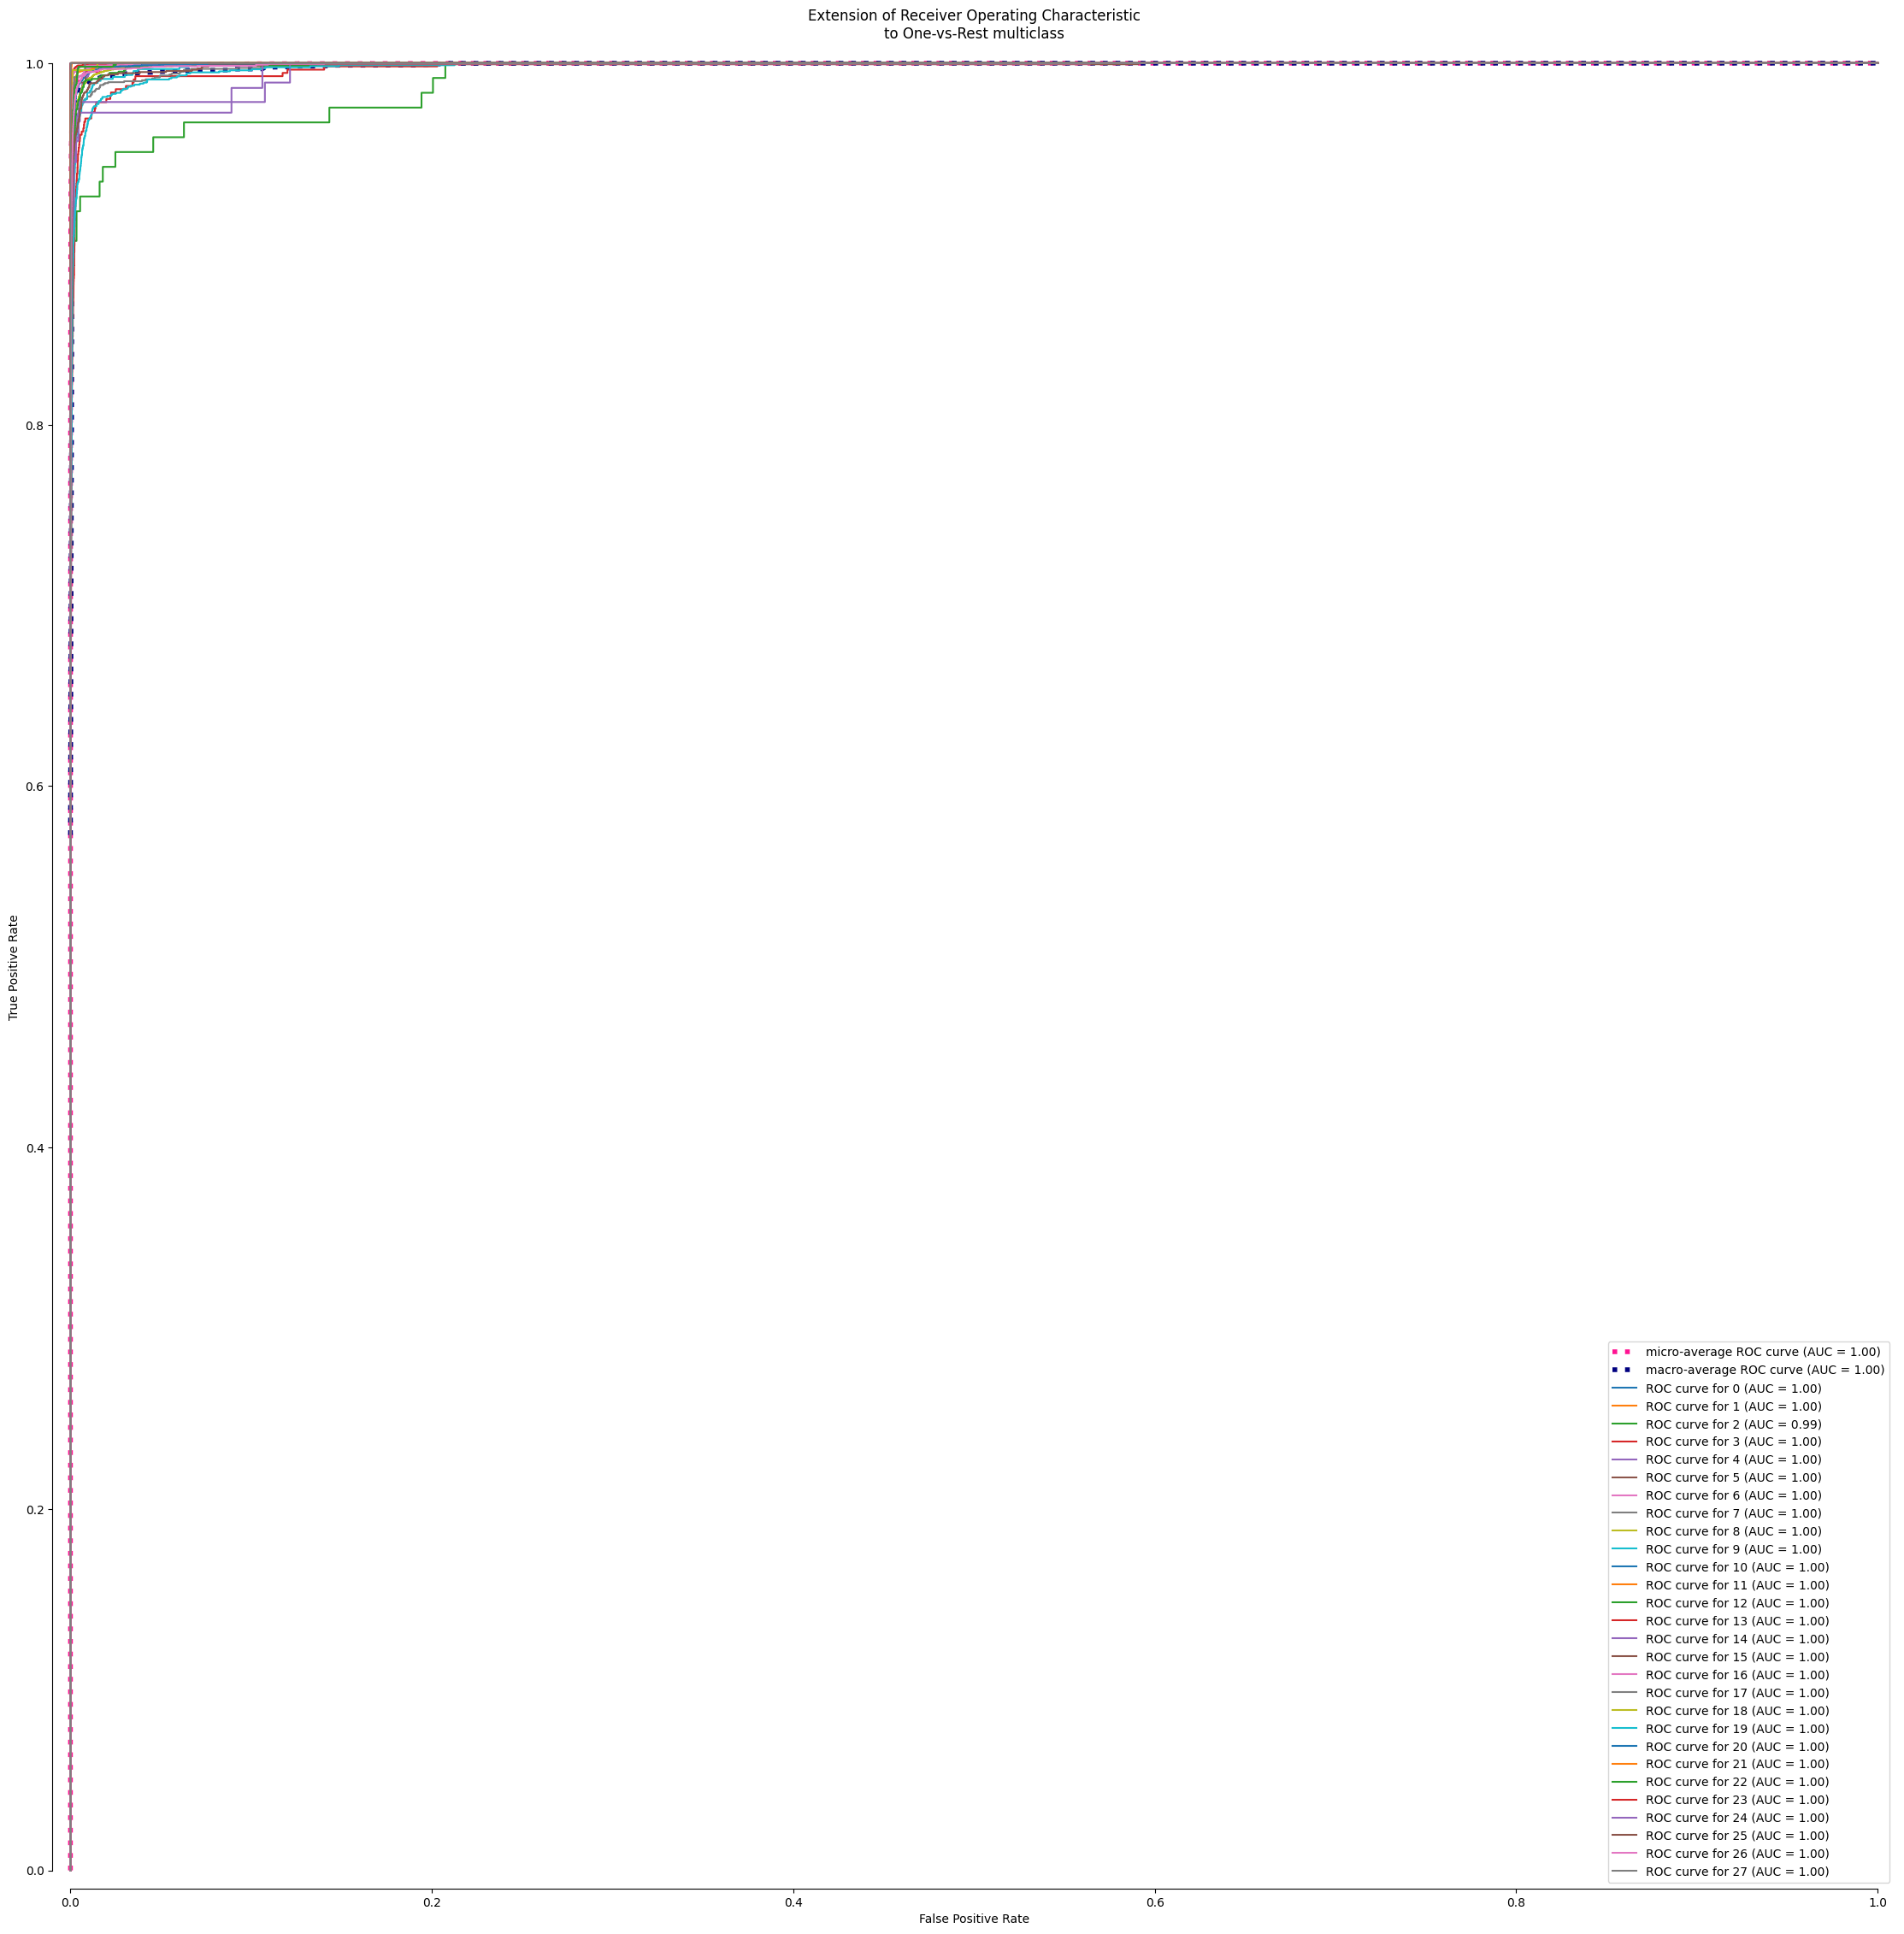

In [90]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(28, 28))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test_type[:, class_id],
        name_type_test_pred[:, class_id],
        name=f"ROC curve for {class_id}", #{target_names[class_id]}
        ax=ax,
        despine=True,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

Tests

In [91]:
df_null = df_test[df_test['category_l2'].isnull()]
df_null.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
7809846,https://cdn1.ozone.ru/s3/multimedia-t/63327116...,"Защитный кейс (бокс, чехол) для карт памяти SD...",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
843680,https://cdn1.ozone.ru/s3/multimedia-1-i/702841...,Аксельбант офицерский желтый,Станок для натягивания проволоки в рамке для пчел,None,None,False,0,nan_False_0
7237878,https://cdn1.ozone.ru/s3/multimedia-1-f/714310...,"Таблетированная соль Rockmelt 4-в-1, 20 кг.",Украшение настольное интерьерное,None,None,False,0,nan_False_0
225586,https://cdn1.ozone.ru/s3/multimedia-1-p/704666...,Набор сверл-метчиков по металлу из быстрорежущ...,Сверло,None,None,False,1,nan_False_1
1567863,https://cdn1.ozone.ru/multimedia/1012292584.jpg,"Одеяло детское Baby Nice ""Божьи коровки"", стег...",Корзина плетеная,None,None,False,0,nan_False_0


In [92]:
text = ' '.join([df_null.loc[7809846]['name'], df_null.loc[7809846]['type']])
text

'Защитный кейс (бокс, чехол) для карт памяти SD, MicroSD Комплект фотоаксессуаров'

In [93]:
text2 = ' '.join([df_null.loc[1567863]['name'], df_null.loc[1567863]['type']])
text2

'Одеяло детское Baby Nice "Божьи коровки", стеганое, цвет: красный, 105 см x 140 см. Q0412123 Корзина плетеная'

In [94]:
df_null.loc[7809846]['main_photo']

'https://cdn1.ozone.ru/s3/multimedia-t/6332711633.jpg'

In [95]:
df_null.loc[1567863]['main_photo']

'https://cdn1.ozone.ru/multimedia/1012292584.jpg'

In [96]:
pred = pd.Series([text, text2], name='data')
pred

0    Защитный кейс (бокс, чехол) для карт памяти SD...
1    Одеяло детское Baby Nice "Божьи коровки", стег...
Name: data, dtype: object

In [97]:
proba = name_type_pipeline.predict_proba(pred)
proba

array([[2.04704112e-06, 5.14901234e-03, 1.07527214e-04, 2.47928579e-04,
        2.47974422e-04, 7.12328554e-05, 6.98695572e-04, 4.32207785e-04,
        1.54681237e-03, 3.91824081e-04, 2.83976300e-05, 1.14561038e-04,
        3.12048325e-04, 2.81363618e-04, 1.27898632e-04, 1.54720375e-04,
        1.22051019e-03, 1.51232230e-04, 2.84797852e-05, 1.52405935e-03,
        1.55046837e-03, 2.31220500e-04, 1.77560634e-04, 3.40923097e-05,
        1.05959432e-04, 4.67195537e-04, 9.84571634e-01, 2.33361554e-05],
       [7.60558374e-06, 1.22042120e-03, 5.22169025e-04, 1.25259435e-03,
        7.18920367e-04, 3.24775732e-04, 3.96450174e-03, 1.75126071e-02,
        9.47973491e-01, 2.38854927e-03, 8.83650779e-05, 3.39154104e-04,
        1.45063328e-03, 3.11862448e-03, 3.17775153e-04, 5.29548827e-04,
        1.86520647e-03, 1.06774547e-03, 1.03631008e-04, 4.68320282e-03,
        1.49592320e-03, 6.51682859e-04, 1.82070407e-03, 8.80083656e-05,
        3.22278064e-04, 5.24557052e-03, 8.50989851e-04, 7.53212

In [98]:
proba[0].argmax(), proba[1].argmax() # 26 - Электроника 8 - Дом и сад 

(np.int64(26), np.int64(8))

In [99]:
label_mapping = dict(zip(range(len(LE.classes_)), LE.classes_))
label_mapping

{0: 'Автомототехника',
 1: 'Автотовары',
 2: 'Антиквариат и коллекционирование',
 3: 'Аптека',
 4: 'Бытовая техника',
 5: 'Бытовая химия',
 6: 'Галантерея и аксессуары',
 7: 'Детские товары',
 8: 'Дом и сад',
 9: 'Канцелярские товары',
 10: 'Кино, музыка, видеоигры, софт',
 11: 'Книги',
 12: 'Красота и гигиена',
 13: 'Мебель',
 14: 'Музыкальные инструменты',
 15: 'Обувь',
 16: 'Одежда',
 17: 'Продукты питания',
 18: 'Продукты питания Ozon Fresh',
 19: 'Спорт и отдых',
 20: 'Строительство и ремонт',
 21: 'Товары для взрослых',
 22: 'Товары для животных',
 23: 'Товары для курения и аксессуары',
 24: 'Фермерское хозяйство',
 25: 'Хобби и творчество',
 26: 'Электроника',
 27: 'Ювелирные изделия'}

In [100]:
import pickle

with open('name_pipeline.pkl', 'wb') as file:
        pickle.dump(name_pipeline, file)


with open('name_type_pipeline.pkl', 'wb') as file:
        pickle.dump(name_type_pipeline, file)

In [101]:
test_y_name_type.to_csv('test_y_name_type.csv')
train_y_name_type.to_csv('train_y_name_type.csv')
name_type_test_pred.tofile('name_type_test_pred.dat')
name_type_train_pred.tofile('name_type_train_pred.dat')
with open('label_mapping.pickle', 'wb') as f:
    pickle.dump(label_mapping, f)